## ΛCDM Cosmological Parameter Estimation with DESI + CMB Data

This notebook derives the cosmological parameters for a **ΛCDM** model by minimizing the joint $\chi^2$ function using both DESI BAO and CMB data.

- **Model:** ΛCDM (with $H_0$, $\Omega_m$, $\Omega_Λ$ as free parameters; $r_d$ is derived from CMB parameters)
- **Data:** DESI BAO measurements + CMB constraints ($\theta_*$, $w_b$, $w_{bc}$, with covariance)
- **Method:**
  - Uses the [`CosmologicalDistances`](../../pyACC/cosmology/distances.py) class from the `pyACC` library
  - Uses the [`LambdaCDM`](../../pyACC/cosmology/cosmology.py) class from the `pyACC` library
  - Parameter estimation performed with `scipy.optimize.minimize`

> **Note:** With DESI data alone, only the product $H_0 \cdot r_d$ can be robustly constrained, not $H_0$ and $r_d$ separately. By including CMB constraints, $r_d$ is determined from $w_b$ and $w_{bc}$, allowing $H_0$ to be fit directly.

# Joint DESI + CMB Likelihood: Adding CMB Constraints

We will add CMB information (on $\theta_*$, $w_b$, $w_{bc}$) to the DESI likelihood, using their means and covariance matrix.

In [7]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u 
import pandas as pd

from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

# I set CMB means and covariance matrix manually
theta_star_mean = 0.010141   # Angular scale of the sound horizon at recombination
w_b_mean = 0.02223           # Physical baryon density
w_bc_mean = 0.14208          # Physical cold dark matter density

Neff = 3.046                 # Effective number of relativistic neutrinos (I'm effectively neglecting the neutrinos mass)

def h(H0):
    return H0 / 100                 # Hubble constant in units of 100 km/s/Mpc (thus dimensionless)
def Omega_b(w_b_mean, H0):
    return w_b_mean / (h(H0)**2)    # Energy baryon ratio
def Omega_m(w_bc_mean, H0):
    return w_bc_mean / (h(H0)**2)   # Energy cold dark matter ratio 

cmb_means = np.array([theta_star_mean, w_b_mean, w_bc_mean])

# Example covariance matrix (replace with actual values)
cmb_cov = np.array([
    [0.006621e-9, 0.12444e-9, -1.1929e-9],
    [0.12444e-9, 21.344e-9, -94.001e-9],
    [-1.1929e-9, -94.001e-9, 1488.4e-9]
])
cmb_cov_inv = np.linalg.inv(cmb_cov)

In [8]:
# Load DESI data from data.csv
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)

z = data["z_eff"].values

D_M_over_r_d = data["D_M / r_d"].values
D_M_over_r_d_err = data["D_M / r_d_err"].values

D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values


## Error propagation for $r_d$ using the CMB means and covariance

I propagate the uncertainties on $w_b$ and $w_{bc}$ to $r_d$ using the derivative error propagation formula for a function of correlated variables.

In [9]:
#from DESI paper (2):
def r_d(w_b, w_bc, Neff=3.046):
    return 147.05 * ((w_b/0.02236)**(-0.13)) * ((w_bc/0.1432)**(-0.23)) * ((Neff/3.046)**(-0.1))

# I compute r_b at the mean values
r_d_val = r_d(w_b_mean, w_bc_mean, Neff)

# Partial derivatives 
drb_dw_b = r_d_val * -0.13 / w_b_mean 
drb_dw_bc = r_d_val * -0.23 / w_bc_mean

# I define the gradient vector (Neff is fixed thus I only have two correlated parameters)
grad = np.array([drb_dw_b, drb_dw_bc])

# I Extract the relevant 2x2 covariance South-East minor for (w_b, w_bc)
cov_wb_wbc = cmb_cov[1:3, 1:3]

#I Propagate the error (for my future self: @ is RxC product)
var_r_b = grad @ cov_wb_wbc @ grad.T
sigma_r_b = np.sqrt(var_r_b)
print(f"r_d = {r_d_val:.3f} ± {sigma_r_b:.3f}")

r_d = 147.428 ± 0.249


## Joint Chi-square Function for DESI + CMB

This function combines the DESI BAO data and the CMB constraints (means and covariance) to find the best-fit LambdaCDM (non-flat) parameters.

In [10]:
from scipy.optimize import minimize

# Now the free parameters are H0, Omega_Lambda, and w_bc (which sets Omega_m via Omega_m = w_bc / (h(H0)**2))

def joint_chi2(params):
    H0, Omega_Lambda, w_bc = params
    Omega_m = w_bc / (h(H0)**2)
    Omega_radiation = 0.0  # for completeness
    model = LambdaCDM(H0, Omega_m, Omega_Lambda, Omega_radiation)

    # DESI chi2: compare D_V/r_d at each z
    D_V_model = np.array([CosmologicalDistances(model.H).volume_distance(z_i) for z_i in z])
    chi2_desi = np.sum(((D_V_obs - D_V_model / r_d_val) / D_V_err) ** 2)

    # CMB chi2: compare model CMB params to means using covariance
    cmb_model = np.array([theta_star_mean, w_b_mean, w_bc])
    delta = cmb_model - cmb_means
    chi2_cmb = delta @ cmb_cov_inv @ delta

    return chi2_desi + chi2_cmb

# Initial guess for H0, Omega_Lambda, w_bc
initial_guess = [70.0, 0.5, w_bc_mean]

# Set reasonable bounds for H0, Omega_Lambda, w_bc
bounds = [(60, 80), (0, 1), (0, 1)]

# Minimize the joint chi-square
result = minimize(joint_chi2, initial_guess, bounds=bounds)

if result.success:
    best_H0, best_Omega_Lambda, best_w_bc = result.x
    best_Omega_m = best_w_bc / (h(best_H0)**2)
    print(f"Best-fit H0: {best_H0:.3f}")
    print(f"Best-fit Omega_m (from w_bc): {best_Omega_m:.4f}")
    print(f"Best-fit Omega_Lambda: {best_Omega_Lambda:.4f}")
    print(f"Best-fit Omega_k: {np.abs(1 - best_Omega_m - best_Omega_Lambda):.4f}")
    print(f"Minimum chi2/dof: {result.fun/3:.2f}")
else:
    print("Minimization failed:", result.message)


# Manca l'erorre su Omega_k

Best-fit H0: 68.775
Best-fit Omega_m (from w_bc): 0.3003
Best-fit Omega_Lambda: 0.7010
Best-fit Omega_k: 0.0013
Minimum chi2/dof: 1.56


## Estimate parameter uncertainties from the inverse Hessian (covariance matrix)

We use the numerical Hessian (second derivatives) at the minimum to estimate the covariance matrix and thus the standard errors on the parameters.

In [11]:
from scipy.optimize import approx_fprime

def get_covariance_matrix(minimum, func, epsilon=1e-5):
    # Numerical Hessian estimation
    n = len(minimum)
    hessian = np.zeros((n, n))
    f0 = func(minimum)
    for i in range(n):
        x1 = np.array(minimum, copy=True)
        x1[i] += epsilon
        grad1 = approx_fprime(x1, func, epsilon)
        x2 = np.array(minimum, copy=True)
        x2[i] -= epsilon
        grad2 = approx_fprime(x2, func, epsilon)
        hessian[:, i] = (grad1 - grad2) / (2 * epsilon)
    cov = np.linalg.inv(hessian)
    return cov

if result.success:
    # Calculate covariance matrix at the minimum
    cov = get_covariance_matrix(result.x, joint_chi2)
    errors = np.sqrt(np.diag(cov))
    print("Parameter uncertainties (1-sigma):")
    print(f"H0: {best_H0:.3f} ± {errors[0]:.3f}")
    print(f"Omega_Lambda: {best_Omega_Lambda:.4f} ± {errors[1]:.4f}")
    print(f"w_bc: {best_w_bc:.5f} ± {errors[2]:.5f}")
    # Propagate error for Omega_m = w_bc / (h(H0)**2)
    # Use error propagation formula for functions of two variables
    h_val = h(best_H0)
    dOmega_m_dH0 = -2 * best_w_bc / (h_val**3 * 100)
    dOmega_m_dwbc = 1 / (h_val**2)
    var_Omega_m = (dOmega_m_dH0**2) * errors[0]**2 + (dOmega_m_dwbc**2) * errors[2]**2
    Omega_m_err = np.sqrt(var_Omega_m)
    print(f"Omega_m (from w_bc): {best_Omega_m:.4f} ± {Omega_m_err:.4f}")

Parameter uncertainties (1-sigma):
H0: 68.775 ± 0.573
Omega_Lambda: 0.7010 ± 0.0193
w_bc: 0.14203 ± 0.00071
Omega_m (from w_bc): 0.3003 ± 0.0052


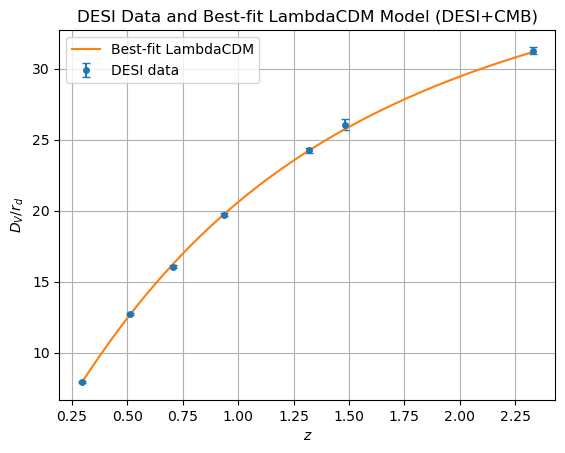

In [12]:
# Plot DESI data and best-fit model
z_plot = np.linspace(np.min(z), np.max(z), 200)
model_best = LambdaCDM(best_H0, best_Omega_m, best_Omega_Lambda)
distances_best = CosmologicalDistances(model_best.H)
D_V_model_plot = np.array([distances_best.volume_distance(z_i) for z_i in z_plot]) / r_d_val

plt.errorbar(z, D_V_obs, yerr=D_V_err, fmt='o', markersize=4, label='DESI data', capsize=3)
plt.plot(z_plot, D_V_model_plot, label='Best-fit LambdaCDM', color='C1')
plt.xlabel(r"$z$")
plt.ylabel(r"$D_V / r_d$")
plt.title("DESI Data and Best-fit LambdaCDM Model (DESI+CMB)")
plt.legend()
plt.grid(True)
plt.show()

#Metropolis simlultanei